In [1]:
import GPy, pandas as pd, numpy as np, scipy as sp, itertools
import GPyNotebook

import seaborn as sns

%matplotlib inline
from matplotlib import pyplot as plt

 :0: FutureWarning:IPython widgets are experimental and may change in the future.


In [2]:
# create sum gaussian distributions based on several variables:
#mixtures = mixtures == mixtures.max(1)[:, None]
#mixtures = np.c_[np.random.dirichlet([.5, .5], size=300), np.random.dirichlet([.3, .7], size=300)]
means = list(itertools.product([-4, 4, 0], repeat=2))
mixtures = np.random.dirichlet(np.random.uniform(0, .2, len(means)), size=300)

In [3]:
def draw_sample(mu, size):
    cov = np.random.normal(size=len(mu))[:,None]
    cov = GPy.util.linalg.tdot(cov) + 1e-6*np.eye(len(mu))
    return np.random.multivariate_normal(mu, cov, size=(300))
    
realizations = (np.array([draw_sample(mu, mixtures.shape[0]) for mu in means]).T * mixtures).sum(-1).T

In [4]:
labels = np.argmax(mixtures, 1)
ulabels = np.unique(labels)

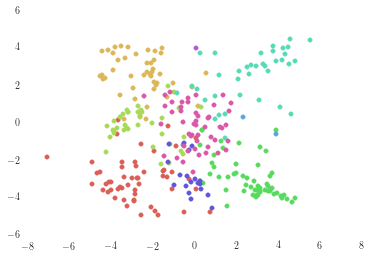

In [5]:
colors = iter(sns.color_palette('hls', mixtures.shape[1]))
for l in ulabels:
    c=colors.next()
    plt.scatter(*realizations[labels==l].T, color=c)

In [6]:
k = GPy.kern.Exponential(2, 1) + GPy.kern.White(2, variance=1e-6)
K = k.K(realizations)

In [7]:
Y = np.random.multivariate_normal(np.zeros(realizations.shape[0]), K, size=23).T

In [8]:
bins = [.1, .7, .9]
labels = np.empty(mixtures.shape)
for i in range(mixtures.shape[0]):
    labels[i] = np.digitize(mixtures[i], bins)

In [9]:
labels = pd.DataFrame(labels, columns = ['var{}'.format(_) for _ in range(labels.shape[1])])

In [10]:
from collections import OrderedDict
labeldict = OrderedDict()
for name, l in labels.iteritems():
    labeldict[name] = l.values

In [ ]:
# Learn the model
Q = 10
m = GPy.models.BayesianGPLVM(Y, Q, num_inducing=30, kernel=GPy.kern.RBF(Q, ARD=True), init='PCA')

In [ ]:
m.likelihood.fix(.01)
m.optimize(messages=1)
m.likelihood.constrain_positive()
m.optimize(messages=1)

Now lets create the visualization. We need to give the latent space (N x Q) and a dictionary of labels (N x #num_labels) to the LatentView instance. There is more options, see the help. Here we generated labels, which are discretized versions of the mixture parameters, which decided how much to take from the different distributions, with different means.

In [ ]:
GPyNotebook.latent.LatentView(m.X.mean, labeldict)

In [ ]:
m.kern.plot_ARD()

In [ ]:
p = GPy.util.pca.PCA(Y)
X_pca = p.project(Y, 10)
GPyNotebook.latent.LatentView(X_pca, labeldict)

In [ ]:
p.plot_fracs(10)